# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Creating dataframe for references of numbers and indices AND the static graph

In this section we will create on one hand a small dataframe containing only the stations that exist in all time range of the data, their coordinates, their number and a numerical index. This index will be used in posterior steps to order the data. Also, we will filter the data to get only the data refering to the stations that exist in the whole time span of the data, as for the GNN we will only use a static graph of the stations existing in all time span.

In [164]:
# creating static graph (only stations that exist in all time range)
data = pd.read_csv("../../data/storage/intermediate/bicimad_dataframe.csv")

In [49]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x',
       'activate', 'name', 'reservations_count', 'light', 'total_bases',
       'free_bases', 'number', 'no_available', 'address', 'dock_bikes',
       'id_station', 'time', 'day', 'month', 'year', 'hour', 'weekday',
       'plugs_count', 'unplugs_count', 'latitude', 'longitude', '81', '82',
       '83', '86', '87', '88', '89', 'Unnamed: 0_y', 'dia_semana',
       'work_day_indicator', 'covid_indicator'],
      dtype='object')

In [50]:
numbers_2019 = data[(data["year"]==2019)&(data["month"]==1)]["number"].unique()
numbers_2020 = data[(data["year"]==2020)&(data["month"]==1)]["number"].unique()
numbers_2021 = data[(data["year"]==2021)&(data["month"]==1)]["number"].unique()
numbers_2022 = data[(data["year"]==2022)&(data["month"]==1)]["number"].unique()

numbers_in_all_years = set(numbers_2019).intersection(numbers_2020, numbers_2021, numbers_2022)

# Convert the set back to a list (if needed)
numbers_in_all_years = list(numbers_in_all_years)

In [51]:
len(data["number"].unique())

266

In [52]:
len(numbers_in_all_years)

170

In [53]:
columns_to_delete = [column for column in data if "Unnamed" in column]
data = data.drop(columns_to_delete, axis = 1)

In [55]:
data_static_graph = data[data["number"].isin(numbers_in_all_years)].reset_index(drop=True)

In [61]:
#saving filtered dataframe
data_static_graph.to_csv("bicimad_dataframe_static_graph.csv", index = False)
data.to_csv("bicimad_dataframe.csv", index = False)

In [56]:
#we want to get a small dataframe containing only number of the station, an index, latitude and longitude
numbers_with_coordinates_static_graph = data.groupby("number").first().reset_index()[["number","latitude","longitude"]]
numbers_with_coordinates_static_graph = numbers_with_coordinates_static_graph[numbers_with_coordinates_static_graph["number"].isin(numbers_in_all_years)].reset_index()
numbers_with_coordinates_static_graph["index"] = np.arange(0,len(numbers_with_coordinates_static_graph))
numbers_with_coordinates_static_graph.head()

,index,number,latitude,longitude
0,0,10,40.425388,-3.690129
1,1,100,40.424780,-3.673840
2,2,101,40.423153,-3.669152
3,3,102,40.421180,-3.684023
4,4,103,40.430370,-3.686530


In [62]:
numbers_with_coordinates_static_graph.to_csv("numbers_with_coordinates_and_indices_static_graph.csv", index = False)

# Observing Adjacency matrix

This matrix expresses the relations between the nodes. Which node is connected with wich node and with which "intensity". This intensity can be measured with some features such as distance between nodes, inverse of distance, time to go from A to B...

### Moving by bike

In [ ]:
A = pd.read_csv("meters_distance_matrix_bike.csv")
A

,0,1,2,3,4,5,6,7,8,9,...,203,204,205,206,207,208,209,210,211,212
0,0,1444,2011,1178,767,124,1891,284,299,686,...,602,1147,439,100,1735,869,1326,1563,1563,2308
1,1396,0,566,1247,1776,1464,2833,1225,1240,1627,...,843,762,1187,1336,2677,1436,855,2169,2169,398
2,2192,797,0,1536,2774,2261,3027,2022,2037,2162,...,1639,1761,1983,2133,3505,1952,1415,2501,2501,1295
3,1017,1367,1933,0,1330,1086,1501,846,862,626,...,524,1069,808,958,1978,417,936,1172,1172,1511
4,804,1727,2293,1412,0,829,2241,633,649,1036,...,1008,1114,919,716,2085,1164,1546,1913,1913,1541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,616,1382,1948,802,928,684,1457,445,460,252,...,539,1084,407,557,1301,0,955,1129,1129,1526
209,1384,784,1144,182,1643,1399,1673,1160,1175,924,...,706,1005,1121,1271,2151,715,0,1345,1345,862
210,1489,2032,2392,1410,2256,1613,1714,1728,1743,784,...,1406,1906,1689,1589,2192,1298,1137,0,0,2110
211,1489,2032,2392,1410,2256,1613,1714,1728,1743,784,...,1406,1906,1689,1589,2192,1298,1137,0,0,2110


Something very interesting to observe, is that the distance is not the same for going from station A to station B, as going from station B to station A. This is due that if you go by bicicle and you need to get in the road, you can not go in any direction, so you need to follow the traffic flow. This forces the user to take different routes to go from A to B or from B to A. When computing the GNN this is a problem, because we want to create a network where every station is a node, and the edges are the connections between nodes. Technically I think it is not possible to put a directional feature in the edges such that distance in one way is one and in the other one is another. For this reason, we will move to walking instead of biking, where the distances should be the same for going from A to B and from B to A while still expressing the geospatial information.

In [16]:
A = pd.read_csv("time_distance_matrix_bike.csv")
A

,0,1,2,3,4,5,6,7,8,9,...,203,204,205,206,207,208,209,210,211,212
0,0,468,544,289,211,23,460,83,86,151,...,184,351,166,20,450,198,357,319,319,563
1,383,0,76,301,409,361,677,300,302,367,...,225,201,315,339,666,345,269,415,415,208
2,568,185,0,348,636,546,732,484,487,514,...,410,428,500,524,820,454,406,489,489,342
3,249,389,465,0,291,227,406,165,168,166,...,105,272,181,205,495,106,228,265,265,439
4,175,412,489,272,0,143,494,117,119,184,...,195,302,164,125,483,193,325,353,353,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,153,415,491,185,194,131,408,69,72,98,...,131,298,84,109,390,0,255,267,267,465
209,316,215,247,26,345,282,397,221,223,212,...,132,291,235,260,485,151,0,256,256,319
210,394,491,523,358,605,417,481,359,362,303,...,299,447,374,414,570,300,304,0,0,595
211,394,491,523,358,605,417,481,359,362,303,...,299,447,374,414,570,300,304,0,0,595


### Moving by walking

Now time and distance between A and B and B and A are the same, which will allow us to build a valid adjacency matrix for computing the GNN.

In [26]:
A = pd.read_csv("data_bicimad/meters_distance_matrix_walking.csv")
A

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,0,1378,1922,953,767,124,1466,216,231,562,...,535,1070,402,74,1202,543,1048,1346,1346,1456
1,1378,0,561,978,1656,1450,2594,1220,1235,1432,...,843,551,1186,1321,2493,1222,784,2026,2026,190
2,1922,534,0,1338,2201,1995,2954,1743,1727,1792,...,1388,1098,1731,1867,2853,1582,1144,2386,2386,735
3,953,978,1338,0,1300,1071,1616,794,779,475,...,524,833,808,943,1688,417,188,993,993,1056
4,767,1654,2200,1300,0,643,2233,633,649,1036,...,836,1105,522,730,1757,928,1395,1820,1820,1467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,543,1222,1582,417,928,670,1577,384,369,251,...,539,1076,407,541,1313,0,512,940,940,1300
166,1048,784,1144,188,1395,1169,1805,888,873,663,...,562,639,906,1041,1783,512,0,1181,1181,862
167,1346,2026,2386,993,1820,1484,1489,1186,1171,784,...,1417,1826,1346,1353,1823,940,1181,0,0,2049
168,1346,2026,2386,993,1820,1484,1489,1186,1171,784,...,1417,1826,1346,1353,1823,940,1181,0,0,2049


ValueError: either both or neither of x and y should be given

In [44]:
A_inverted_dist = np.divide(1,A)
A_inverted_dist[np.isinf(A_inverted_dist)] = 0
# Calculate the norm of the matrix
norm = np.linalg.norm(A_inverted_dist)

# Normalize the matrix
A_inverted_dist_norm = A_inverted_dist / norm
A_inverted_dist_norm

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,0.000000,0.004453,0.003192,0.006438,0.008000,0.049483,0.004185,0.028407,0.026562,0.010918,...,0.011469,0.005734,0.015263,0.082917,0.005105,0.011300,0.005855,0.004559,0.004559,0.004214
1,0.004453,0.000000,0.010937,0.006274,0.003705,0.004232,0.002365,0.005029,0.004968,0.004285,...,0.007279,0.011136,0.005174,0.004645,0.002461,0.005021,0.007826,0.003029,0.003029,0.032294
2,0.003192,0.011490,0.000000,0.004586,0.002788,0.003076,0.002077,0.003520,0.003553,0.003424,...,0.004421,0.005588,0.003545,0.003286,0.002151,0.003879,0.005364,0.002572,0.002572,0.008348
3,0.006438,0.006274,0.004586,0.000000,0.004720,0.005729,0.003797,0.007728,0.007877,0.012918,...,0.011710,0.007366,0.007594,0.006507,0.003635,0.014714,0.032638,0.006179,0.006179,0.005810
4,0.008000,0.003710,0.002789,0.004720,0.000000,0.009543,0.002748,0.009693,0.009454,0.005923,...,0.007340,0.005553,0.011755,0.008405,0.003492,0.006612,0.004398,0.003371,0.003371,0.004183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.011300,0.005021,0.003879,0.014714,0.006612,0.009158,0.003891,0.015979,0.016628,0.024446,...,0.011384,0.005702,0.015076,0.011342,0.004673,0.000000,0.011984,0.006528,0.006528,0.004720
166,0.005855,0.007826,0.005364,0.032638,0.004398,0.005249,0.003399,0.006910,0.007028,0.009255,...,0.010918,0.009602,0.006772,0.005894,0.003441,0.011984,0.000000,0.005195,0.005195,0.007118
167,0.004559,0.003029,0.002572,0.006179,0.003371,0.004135,0.004121,0.005174,0.005240,0.007826,...,0.004330,0.003360,0.004559,0.004535,0.003366,0.006528,0.005195,0.000000,0.000000,0.002995
168,0.004559,0.003029,0.002572,0.006179,0.003371,0.004135,0.004121,0.005174,0.005240,0.007826,...,0.004330,0.003360,0.004559,0.004535,0.003366,0.006528,0.005195,0.000000,0.000000,0.002995


In [46]:
np.save("data_bicimad/adj_mat_inverted_dist.npy",np.array(A_inverted_dist_norm))

In [18]:
D = pd.read_csv("time_distance_matrix_walking.csv")
D

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,0,1133,1510,760,620,99,1107,175,186,435,...,440,881,330,61,932,428,840,1017,1017,1192
1,1015,0,393,738,1252,1073,1949,897,908,1052,...,631,418,893,978,1883,911,603,1471,1471,163
2,1429,418,0,1017,1665,1488,2227,1301,1290,1331,...,1044,834,1306,1393,2161,1190,882,1749,1749,581
3,686,780,1020,0,969,771,1211,561,550,328,...,372,641,590,676,1266,297,145,720,720,840
4,549,1288,1664,961,0,453,1654,455,466,751,...,613,847,368,507,1344,659,1040,1336,1336,1146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,394,993,1233,337,705,486,1175,269,258,175,...,416,851,305,391,1000,0,415,693,693,1052
166,753,631,871,131,1034,840,1342,628,617,459,...,395,493,657,745,1333,362,0,852,852,691
167,1010,1578,1818,787,1409,1113,1155,887,876,591,...,1086,1428,1024,1017,1418,719,931,0,0,1626
168,1010,1578,1818,787,1409,1113,1155,887,876,591,...,1086,1428,1024,1017,1418,719,931,0,0,1626


In [19]:
np.save("meters_distance_matrix_walking.npy",np.array(A))
np.save("time_distance_matrix_walking.npy",np.array(D))

# Preprocessing

Now we need to prepare the data for the GNN and XGBoost. 

The data for GNN data will need to contain the following:
- edges: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
- edge_weights: Edge feature matrix with shape [num_edges, num_edge_features]. For us it will be [num_edges, 1], we will only use the distance or time.
- features: Node feature matrix with shape [data points (num_nodes*quantity of time periods registered), num_node_features]
- targets: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

All data independently of the model, will be preprocessed, cleaned and standardized. Then, regarding GNN, it will be reshaped into the features matrix shape, and saved as a numpy array to be loaded in the training script. For XGBoost, the data will be saved into a csv file.

### Compleeting indices for all data

The numbers_with_coordinates_and_indices_static_graph.csv file only contains the indices of the static graph. To make xgboost data coherent too, we will need to add those indices.

In [137]:
numbers_code_coordinates_static_graph = pd.read_csv(os.path.join("data_bicimad","numbers_with_coordinates_and_indices_static_graph.csv"))

In [274]:
data_static_graph = pd.read_csv(os.path.join("data_bicimad","bicimad_dataframe_static_graph.csv"))
data = pd.read_csv(os.path.join("data_bicimad","bicimad_dataframe.csv"))

For some reason, there is a duplicated hour in both dataframes (year=2019,month=2,day=1,hour=0). We are going to remove duplicates for future processing.

In [289]:
import datetime as dt
fixed_hour = data[pd.to_datetime(data["time"]) == dt.datetime(year=2019,month=2,day=1,hour=0)].drop_duplicates()
#removing the hour with duplicates
data = data[pd.to_datetime(data["time"]) != dt.datetime(year=2019,month=2,day=1,hour=0)]
#adding the hour without duplicates
data = pd.concat([data, fixed_hour])

fixed_hour = data_static_graph[pd.to_datetime(data_static_graph["time"]) == dt.datetime(year=2019,month=2,day=1,hour=0)].drop_duplicates()
#removing the hour with duplicates
data_static_graph = data_static_graph[pd.to_datetime(data_static_graph["time"]) != dt.datetime(year=2019,month=2,day=1,hour=0)]
#adding the hour without duplicates
data_static_graph = pd.concat([data_static_graph, fixed_hour])


In [143]:
stations_static_graph = numbers_code_coordinates_static_graph["number"].unique()
stations_total = data["number"].unique()

numbers_code_coordinates = data.groupby("number").first().reset_index()[["number","latitude","longitude"]]
numbers_code_coordinates = numbers_code_coordinates.merge(numbers_code_coordinates_static_graph[["number","index"]], on = "number", how = "left")

numbers_code_coordinates.loc[numbers_code_coordinates["index"].isna(),"index"] = np.arange(len(stations_static_graph),len(stations_total))

In [152]:
numbers_code_coordinates.to_csv(os.path.join("data_bicimad","numbers_with_coordinates_and_indices.csv"))

### Ordering data

IMPORTANT!! Features will be ordered first by time (year,month,day,hour) but then stations need to be ordered in the same way as the nodes. Node with index 0 which represents station with index 0, will be related to the first row in the data. The data will be inputed as a pytorch tensor, so we need to make sure it is ordered previously. So the data will need to be ordered by year, month, day, hour AND station index, which is a variable that has veen created in "numbers_with_coordinates_and_indices.csv"

In [291]:
data_static_graph_index = data_static_graph.merge(numbers_code_coordinates_static_graph[["number", "index"]], on="number", how = "left").reset_index()
data_index = data.merge(numbers_code_coordinates[["number", "index"]], on="number", how = "left").reset_index()

In [295]:
#ordering data
data_static_graph_index = data_static_graph_index.sort_values(by = ["year","month","day","hour","index"], ascending=[True,True,True,True,True], ignore_index=True)
data_static_graph_index = data_static_graph_index.drop("level_0",axis = 1)

data_index = data_index.sort_values(by = ["year","month","day","hour","index"], ascending=[True,True,True,True,True], ignore_index=True)
data_index = data_index.drop("level_0",axis = 1)

data_static_graph_index[["year","month","day","hour","index","weekday"]]

,year,month,day,hour,index,weekday
0,2019,1,1,0.0,0.0,1
1,2019,1,1,0.0,1.0,1
2,2019,1,1,0.0,2.0,1
3,2019,1,1,0.0,3.0,1
4,2019,1,1,0.0,4.0,1
...,...,...,...,...,...,...
5960875,2022,12,31,23.0,165.0,5
5960876,2022,12,31,23.0,166.0,5
5960877,2022,12,31,23.0,167.0,5
5960878,2022,12,31,23.0,168.0,5


### Feature engineering

There is a lot of feature engieering to be done here like making cyclic month, day, hour, wind direction, day of the week...

### Adding week number of the year and week index of all dataset

In [296]:
data_static_graph_index['week_of_year'] = pd.to_datetime(data_static_graph_index['time']).apply(lambda x: int(x.strftime('%U')))
data_index['week_of_year'] = pd.to_datetime(data_index['time']).apply(lambda x: int(x.strftime('%U')))

In [297]:
data_static_graph_index['year_week_index'] = data_static_graph_index.apply(lambda x: int(str(x['year']) + str(x['week_of_year'])), axis = 1)
data_index['year_week_index'] = data_index.apply(lambda x: int(str(x['year']) + str(x['week_of_year'])), axis = 1)

#### Cyclic variables

The cyclic features will be ['month','day','hour',"weekday"], and also wind speed in x and y coordinates. At this time, wind is explained with 2 variables, wind speed and wind direction (in degrees).

In [298]:
data_static_graph_index.columns

Index(['activate', 'name', 'reservations_count', 'light', 'total_bases',
       'free_bases', 'number', 'no_available', 'address', 'dock_bikes',
       'id_station', 'time', 'day', 'month', 'year', 'hour', 'weekday',
       'plugs_count', 'unplugs_count', 'latitude', 'longitude', '81', '82',
       '83', '86', '87', '88', '89', 'dia_semana', 'work_day_indicator',
       'covid_indicator', 'index', 'week_of_year', 'year_week_index'],
      dtype='object')

In [299]:
from feature_engine.creation import CyclicalFeatures

cyclical_features = ['month','day','hour',"weekday","week_of_year"]
cf = CyclicalFeatures()
cf.fit(data_index[cyclical_features])

data_static_graph_index = pd.concat([data_static_graph_index, cf.transform(data_static_graph_index[cyclical_features]).drop(cyclical_features, axis=1)], axis=1).drop(cyclical_features, axis=1)
data_index = pd.concat([data_index, cf.transform(data_index[cyclical_features]).drop(cyclical_features, axis=1)], axis=1).drop(cyclical_features, axis=1)

In [300]:
data_static_graph_index[[column for column in data_static_graph_index.columns if any(feature in column for feature in cyclical_features)]].head()

,work_day_indicator,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,weekday_sin,weekday_cos,week_of_year_sin,week_of_year_cos
0,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0
1,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0
2,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0
3,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0
4,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0


In [301]:
data_index[[column for column in data_index.columns if any(feature in column for feature in cyclical_features)]].head()

,work_day_indicator,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,weekday_sin,weekday_cos,week_of_year_sin,week_of_year_cos
0,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0
1,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0
2,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0
3,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0
4,0,0.5,0.866025,0.201299,0.97953,0.0,1.0,0.866025,0.5,0.0,1.0


In [302]:
def wind_to_xy(df):
    wind_cos = df["81"]*np.cos(df["82"])
    wind_sin = df["81"]*np.sin(df["82"])

    df = df.drop(["81","82"], axis = 1)
    df["wind_cos"] = wind_cos
    df["wind_sin"] = wind_sin

    return df

data_static_graph_index = wind_to_xy(data_static_graph_index)
data_index = wind_to_xy(data_index)

data_static_graph_index[["wind_cos","wind_sin"]].head()

,wind_cos,wind_sin
0,-0.478525,-0.439902
1,-0.015194,0.013006
2,0.179993,-0.001588
3,-0.015194,0.013006
4,-0.015194,0.013006


In [303]:
data_static_graph_index.columns

Index(['activate', 'name', 'reservations_count', 'light', 'total_bases',
       'free_bases', 'number', 'no_available', 'address', 'dock_bikes',
       'id_station', 'time', 'year', 'plugs_count', 'unplugs_count',
       'latitude', 'longitude', '83', '86', '87', '88', '89', 'dia_semana',
       'work_day_indicator', 'covid_indicator', 'index', 'year_week_index',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'week_of_year_sin', 'week_of_year_cos',
       'wind_cos', 'wind_sin'],
      dtype='object')

### Categorical features

light variable: [0,1,2,3]. This represents occupation of bike stations. (0.-low, 2.- medium, 1.- high, 3.- Unavailable)

In [304]:
from sklearn.preprocessing import OneHotEncoder

# Create and fit the OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(data_static_graph_index["light"].values.reshape(-1,1))

# Perform one-hot encoding
data_static_graph_index[["light0","light1","light2","light3"]]=encoder.transform(data_static_graph_index["light"].values.reshape(-1,1)).toarray()
data_static_graph_index = data_static_graph_index.drop("light", axis = 1)

data_index[["light0","light1","light2","light3"]]=encoder.transform(data_index["light"].values.reshape(-1,1)).toarray()
data_index = data_index.drop("light", axis = 1)

In [305]:
data_index.columns

Index(['activate', 'name', 'reservations_count', 'total_bases', 'free_bases',
       'number', 'no_available', 'address', 'dock_bikes', 'id_station', 'time',
       'year', 'plugs_count', 'unplugs_count', 'latitude', 'longitude', '83',
       '86', '87', '88', '89', 'dia_semana', 'work_day_indicator',
       'covid_indicator', 'index', 'year_week_index', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos', 'week_of_year_sin', 'week_of_year_cos', 'wind_cos',
       'wind_sin', 'light0', 'light1', 'light2', 'light3'],
      dtype='object')

Saving data_index file, this file will be standardized and splited in Erika's code.

In [306]:
data_index.to_csv(os.path.join("data_bicimad","preprocessed", "XGBoost_data_not_standardized_or_splited.csv"))

## PREPARING GNN
From now on, next steps will focus on preparing GNN data

### Splitting data

For training, we will separate the data into weeks to predict with one week the values of the following week, so we need to make the data multiple of 7 first. To do so, we will count the number of days (365·3+366 = 1461), 1461/7 = 208.7, so we will need to get only 208·7 days. That is 1456, so we need to delete the last 5 days of the year. That multiplied by the 170 stations (for GNN) and 24 hours is a total of 20400 rows. In the case of XGBoost, it will use all stations (and for 2022 the number fo stations is 264), so the total number of rows to delete will be 5·24·264 = 31680.

In [200]:
#filtering so that we only have full weeks
#data_static_graph_index = data_static_graph_index[:-5*24*170]
#data_index = data_index[:-5*24*264]


IMPORTANT!! When splitting, if the model is going to be trained with a window, the data structure and inherent information has to be the same for test and train. As an example, GNN will be trained in windows that will cover whole weeks with the idea that the model learns to predict from one week the values for next week. For this reason it is important that both datasets (train and test) start with the same day of the week. The first year of the train split will be 2019. This year starts in a tuesday. The last year of the time split is 2021, and 2022 starts on a saturday.

We will split the datasets in the following way:
When test set is all 2022
- train set: from 6/1/2019 (sunday) to 1/12/2021 (saturday)
- test set: from 2/1/2022 (sunday) to 31/12/2022 (saturday)

when test set is innova's week:
- train set: from 6/1/2019 (sunday) to 12/6/2021 (saturday)
- test set: from 13/6/2021 (sunday) to 3/7/2021 (saturday)

we need the weeks to go from saturday to sunday so that they are in the same format Erika is going to use



In [307]:
import datetime as dt

data_static_graph_index['time'] = pd.to_datetime(data_static_graph_index['time'])

train_GNN_2022 = data_static_graph_index[(data_static_graph_index["time"]>=dt.datetime(year=2019,month=1,day=6,hour=0))&
                                           (data_static_graph_index["time"]<dt.datetime(year=2022,month=1,day=2,hour=0))]

test_GNN_2022 = data_static_graph_index[(data_static_graph_index["time"]>=dt.datetime(year=2022,month=1,day=2,hour=0))&
                                           (data_static_graph_index["time"]<dt.datetime(year=2023,month=1,day=1,hour=0))]

train_GNN_innova = data_static_graph_index[(data_static_graph_index["time"]>=dt.datetime(year=2019,month=1,day=6,hour=0))&
                                           (data_static_graph_index["time"]<dt.datetime(year=2021,month=6,day=13,hour=0))]
test_GNN_innova = data_static_graph_index[(data_static_graph_index["time"]>=dt.datetime(year=2021,month=6,day=13,hour=0))&
                                           (data_static_graph_index["time"]<dt.datetime(year=2021,month=7,day=4,hour=0))]

#data_index['time'] = pd.to_datetime(data_index['time'])
#train_XGBoost = data_index[data_index["time"]<dt.datetime(year=2022,month=1,day=1)]
#test_XGBoost = data_index[data_index["time"]>=dt.datetime(year=2022,month=1,day=1)]

### Saving dataframes before standardizing

In [318]:
# saving dataframes
train_GNN_2022.to_csv(os.path.join("data_bicimad","preprocessed", "train_GNN_2022.csv"))
test_GNN_2022.to_csv(os.path.join("data_bicimad","preprocessed", "test_GNN_2022.csv"))

train_GNN_innova.to_csv(os.path.join("data_bicimad","preprocessed", "train_GNN_innova.csv"))
test_GNN_innova.to_csv(os.path.join("data_bicimad","preprocessed", "test_GNN_innova.csv"))

## Preparing for GNN

In [5]:
train_GNN_2022 = pd.read_csv(os.path.join("data_bicimad","preprocessed", "train_GNN_2022_no_standarized.csv"))
test_GNN_2022 = pd.read_csv(os.path.join("data_bicimad","preprocessed", "test_GNN_2022_no_standarized.csv"))

train_GNN_innova = pd.read_csv(os.path.join("data_bicimad","preprocessed", "train_GNN_innova_no_standarized.csv"))
test_GNN_innova = pd.read_csv(os.path.join("data_bicimad","preprocessed", "test_GNN_innova_no_standarized.csv"))

### Standardizing

In [6]:
train_GNN_2022.describe()

,Unnamed: 0,activate,reservations_count,total_bases,free_bases,no_available,dock_bikes,id_station,year,plugs_count,...,weekday_sin,weekday_cos,week_of_year_sin,week_of_year_cos,wind_cos,wind_sin,light0,light1,light2,light3
count,4.455360e+06,4455360.0,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,...,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06,4.455360e+06
mean,2.248080e+06,1.0,6.387138e-02,2.383354e+01,1.216617e+01,5.385805e-02,8.864553e+00,8.937059e+01,2.020006e+03,2.191409e+00,...,-6.573145e-17,1.428571e-01,-5.458857e-17,5.552471e-17,-2.673197e-02,-1.900224e-02,3.873873e-01,1.641353e-01,3.946193e-01,5.385805e-02
std,1.286152e+06,0.0,2.771624e-01,2.079976e+00,7.968114e+00,2.257374e-01,7.760484e+00,5.046139e+01,8.170321e-01,3.256031e+00,...,6.546537e-01,7.423076e-01,7.071069e-01,7.071069e-01,1.077328e+00,1.081634e+00,4.871534e-01,3.703984e-01,4.887688e-01,2.257374e-01
min,2.040000e+04,1.0,0.000000e+00,1.200000e+01,-2.870000e+02,0.000000e+00,-1.570000e+02,1.000000e+00,2.019000e+03,0.000000e+00,...,-8.660254e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-7.839746e+00,-9.409242e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.134240e+06,1.0,0.000000e+00,2.400000e+01,7.000000e+00,0.000000e+00,3.000000e+00,4.600000e+01,2.019000e+03,0.000000e+00,...,-8.660254e-01,-5.000000e-01,-6.844697e-01,-6.844697e-01,-6.109706e-01,-6.140244e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.248080e+06,1.0,0.000000e+00,2.400000e+01,1.300000e+01,0.000000e+00,8.000000e+00,9.050000e+01,2.020000e+03,1.000000e+00,...,0.000000e+00,5.000000e-01,6.123234e-17,-6.123234e-17,-3.296665e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.361919e+06,1.0,0.000000e+00,2.400000e+01,1.800000e+01,0.000000e+00,1.300000e+01,1.330000e+02,2.021000e+03,3.000000e+00,...,8.660254e-01,1.000000e+00,6.844697e-01,6.844697e-01,5.637638e-01,5.722003e-01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,4.475759e+06,1.0,4.000000e+00,3.000000e+01,1.810000e+02,1.000000e+00,3.110000e+02,1.750000e+02,2.022000e+03,2.390000e+02,...,8.660254e-01,1.000000e+00,1.000000e+00,1.000000e+00,8.841346e+00,8.760660e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
colums_to_standardize = ["reservations_count","total_bases","free_bases","dock_bikes","year","83","86","87","88","89"]

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

train_GNN_2022_std = train_GNN_2022.copy()
test_GNN_2022_std = test_GNN_2022.copy()

train_GNN_innova_std = train_GNN_innova.copy()
test_GNN_innova_std = test_GNN_innova.copy()

train_GNN_2022_minmax = train_GNN_2022.copy()
test_GNN_2022_minmax = test_GNN_2022.copy()

train_GNN_innova_minmax = train_GNN_innova.copy()
test_GNN_innova_minmax = test_GNN_innova.copy()

# std scaler
train_GNN_2022_std[colums_to_standardize] = std_scaler.fit_transform(train_GNN_2022_std[colums_to_standardize])
test_GNN_2022_std[colums_to_standardize] = std_scaler.transform(test_GNN_2022_std[colums_to_standardize])

train_GNN_innova_std[colums_to_standardize] = std_scaler.fit_transform(train_GNN_innova_std[colums_to_standardize])
test_GNN_innova_std[colums_to_standardize] = std_scaler.transform(test_GNN_innova_std[colums_to_standardize])

# minmax scaler
train_GNN_2022_minmax[colums_to_standardize] = minmax_scaler.fit_transform(train_GNN_2022_minmax[colums_to_standardize])
test_GNN_2022_minmax[colums_to_standardize] = minmax_scaler.transform(test_GNN_2022_minmax[colums_to_standardize])

train_GNN_innova_minmax[colums_to_standardize] = minmax_scaler.fit_transform(train_GNN_innova_minmax[colums_to_standardize])
test_GNN_innova_minmax[colums_to_standardize] = minmax_scaler.transform(test_GNN_innova_minmax[colums_to_standardize])

### Deletting unnecessary columns

In [8]:
train_GNN_2022.columns

Index(['Unnamed: 0', 'activate', 'name', 'reservations_count', 'total_bases',
       'free_bases', 'number', 'no_available', 'address', 'dock_bikes',
       'id_station', 'time', 'year', 'plugs_count', 'unplugs_count',
       'latitude', 'longitude', '83', '86', '87', '88', '89', 'dia_semana',
       'work_day_indicator', 'covid_indicator', 'index', 'year_week_index',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'week_of_year_sin', 'week_of_year_cos',
       'wind_cos', 'wind_sin', 'light0', 'light1', 'light2', 'light3'],
      dtype='object')

In [9]:
# deleting categorical, id and location variables
columns_to_drop_GNN = ["name", "number","address","id_station","latitude","longitude","dia_semana","time","year_week_index","index"]
#columns_to_drop_XGBoost = ["name", "number","address","id_station","latitude","longitude","dia_semana"]

train_GNN_2022_std = train_GNN_2022_std.drop(columns_to_drop_GNN, axis = 1)
test_GNN_2022_std = test_GNN_2022_std.drop(columns_to_drop_GNN, axis = 1)

train_GNN_innova_std = train_GNN_innova_std.drop(columns_to_drop_GNN, axis = 1)
test_GNN_innova_std = test_GNN_innova_std.drop(columns_to_drop_GNN, axis = 1)

train_GNN_2022_minmax = train_GNN_2022_minmax.drop(columns_to_drop_GNN, axis = 1)
test_GNN_2022_minmax = test_GNN_2022_minmax.drop(columns_to_drop_GNN, axis = 1)

train_GNN_innova_minmax = train_GNN_innova_minmax.drop(columns_to_drop_GNN, axis = 1)
test_GNN_innova_minmax = test_GNN_innova_minmax.drop(columns_to_drop_GNN, axis = 1)

In [10]:
# ensuring that all variables except time for XGBoost dataframe are float
for column in train_GNN_2022_std.columns:
    train_GNN_2022_std[column] = train_GNN_2022_std[column].astype(float)
    test_GNN_2022_std[column] = test_GNN_2022_std[column].astype(float)

    train_GNN_innova_std[column] = train_GNN_innova_std[column].astype(float)
    test_GNN_innova_std[column] = test_GNN_innova_std[column].astype(float)

    train_GNN_2022_minmax[column] = train_GNN_2022_minmax[column].astype(float)
    test_GNN_2022_minmax[column] = test_GNN_2022_minmax[column].astype(float)

    train_GNN_innova_minmax[column] = train_GNN_innova_minmax[column].astype(float)
    test_GNN_innova_minmax[column] = test_GNN_innova_minmax[column].astype(float)

In [11]:
train_GNN_innova_minmax.columns

Index(['Unnamed: 0', 'activate', 'reservations_count', 'total_bases',
       'free_bases', 'no_available', 'dock_bikes', 'year', 'plugs_count',
       'unplugs_count', '83', '86', '87', '88', '89', 'work_day_indicator',
       'covid_indicator', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'week_of_year_sin', 'week_of_year_cos', 'wind_cos', 'wind_sin',
       'light0', 'light1', 'light2', 'light3'],
      dtype='object')

In [12]:
train_GNN_innova_minmax.columns

Index(['Unnamed: 0', 'activate', 'reservations_count', 'total_bases',
       'free_bases', 'no_available', 'dock_bikes', 'year', 'plugs_count',
       'unplugs_count', '83', '86', '87', '88', '89', 'work_day_indicator',
       'covid_indicator', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'week_of_year_sin', 'week_of_year_cos', 'wind_cos', 'wind_sin',
       'light0', 'light1', 'light2', 'light3'],
      dtype='object')

In [14]:
#we order the dataframes so that target variables are at the start
order = ['plugs_count', 'unplugs_count','activate', 'reservations_count', 'total_bases', 'free_bases',
       'no_available', 'dock_bikes', 'year', 
       '83', '86', '87', '88', '89', 'work_day_indicator', 'covid_indicator', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin',
       'hour_cos', 'weekday_sin', 'weekday_cos', 'week_of_year_sin',
       'week_of_year_cos', 'wind_cos', 'wind_sin', 'light0', 'light1',
       'light2', 'light3']

train_GNN_2022_std = train_GNN_2022_std[order]
test_GNN_2022_std = test_GNN_2022_std[order]

train_GNN_innova_std = train_GNN_innova_std[order]
test_GNN_innova_std = test_GNN_innova_std[order]

train_GNN_2022_minmax = train_GNN_2022_minmax[order]
test_GNN_2022_minmax = test_GNN_2022_minmax[order]

train_GNN_innova_minmax = train_GNN_innova_minmax[order]
test_GNN_innova_minmax = test_GNN_innova_minmax[order]

In [15]:
train_GNN_2022_std_numpy = np.array(train_GNN_2022_std).reshape((int(len(train_GNN_2022_std)/170),170,len(train_GNN_2022_std.columns)))
test_GNN_2022_std_numpy = np.array(test_GNN_2022_std).reshape((int(len(test_GNN_2022_std)/170),170,len(test_GNN_2022_std.columns)))

train_GNN_innova_std_numpy = np.array(train_GNN_innova_std).reshape((int(len(train_GNN_innova_std)/170),170,len(train_GNN_innova_std.columns)))
test_GNN_innova_std_numpy = np.array(test_GNN_innova_std).reshape((int(len(test_GNN_innova_std)/170),170,len(test_GNN_innova_std.columns)))

train_GNN_2022_minmax_numpy = np.array(train_GNN_2022_minmax).reshape((int(len(train_GNN_2022_minmax)/170),170,len(train_GNN_2022_minmax.columns)))
test_GNN_2022_minmax_numpy = np.array(test_GNN_2022_minmax).reshape((int(len(test_GNN_2022_minmax)/170),170,len(test_GNN_2022_minmax.columns)))

train_GNN_innova_minmax_numpy = np.array(train_GNN_innova_minmax).reshape((int(len(train_GNN_innova_minmax)/170),170,len(train_GNN_innova_minmax.columns)))
test_GNN_innova_minmax_numpy = np.array(test_GNN_innova_minmax).reshape((int(len(test_GNN_innova_minmax)/170),170,len(test_GNN_innova_minmax.columns)))

### Saving data files

In [18]:
# saving dataframes
np.save(os.path.join("data_bicimad","preprocessed", "train_GNN_2022_std.npy"),train_GNN_2022_std_numpy)
np.save(os.path.join("data_bicimad","preprocessed", "test_GNN_2022_std.npy"),test_GNN_2022_std_numpy)

np.save(os.path.join("data_bicimad","preprocessed", "train_GNN_innova_std.npy"),train_GNN_innova_std_numpy)
np.save(os.path.join("data_bicimad","preprocessed", "test_GNN_innova_std.npy"),test_GNN_innova_std_numpy)

np.save(os.path.join("data_bicimad","preprocessed", "train_GNN_2022_minmax.npy"),train_GNN_2022_minmax_numpy)
np.save(os.path.join("data_bicimad","preprocessed", "test_GNN_2022_minmax.npy"),test_GNN_2022_minmax_numpy)

np.save(os.path.join("data_bicimad","preprocessed", "train_GNN_innova_minmax.npy"),train_GNN_innova_minmax_numpy)
np.save(os.path.join("data_bicimad","preprocessed", "test_GNN_innova_minmax.npy"),test_GNN_innova_minmax_numpy)

In [43]:
train_GNN_std_index = pd.read_csv(os.path.join("data_bicimad","preprocessed", "train_GNN_std.csv"))


In [39]:
train_GNN_std.columns

Index(['plugs_count', 'unplugs_count', 'activate', 'reservations_count',
       'total_bases', 'free_bases', 'no_available', 'dock_bikes', 'year', '83',
       '86', '87', '88', '89', 'work_day_indicator', 'covid_indicator',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'wind_cos', 'wind_sin', 'light0',
       'light1', 'light2', 'light3'],
      dtype='object')

<Axes: >

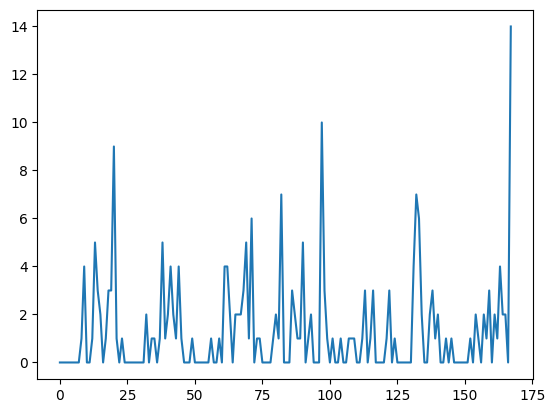

In [48]:
train_GNN_std_numpy

import seaborn as sns
# Visualize traffic over time
hours = 168
sensor_labels = train_GNN_std_numpy[hours:2*hours,0,0]
sns.lineplot(data=sensor_labels)

In [49]:
train_GNN_std_index["index"].nunique()

169

<Axes: ylabel='plugs_count'>

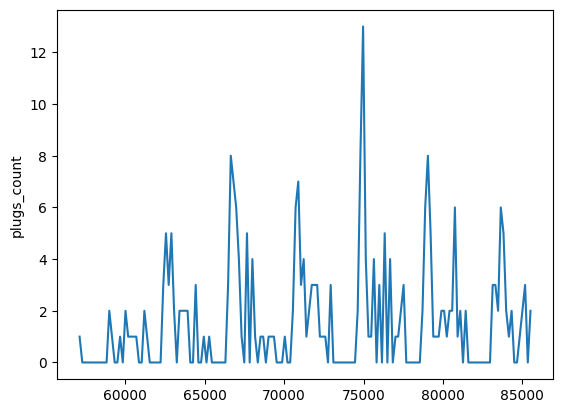

In [25]:
import seaborn as sns
# Visualize traffic over time
hours = 168
sensor_labels = train_GNN_2022[train_GNN_2022["index"]==0].iloc[168*2:3*168]["plugs_count"]
sns.lineplot(data=sensor_labels)

# NOT USED

### Lagged variables

Now, we will create the lagged variables for plugs and unplugs of last week, so that for week 2, at monday at 10 am, the model will have the information of plugs and unplugs at monday at 10 am of the previous week for each station. As the data will be ordered in the following order (year, month, day, hour, station), creating the lagged variable will be as simple as shifting the target for 7*24*170 = 28560 rows.

In [ ]:
data_static_graph_index[["year","month","day","hour","index","weekday","unplugs_count"]][0:]

,year,month,day,hour,index,weekday,unplugs_count
0,2019,1,1,0.0,0,1,0.0
1,2019,1,1,0.0,1,1,1.0
2,2019,1,1,0.0,2,1,2.0
3,2019,1,1,0.0,3,1,1.0
4,2019,1,1,0.0,4,1,1.0
...,...,...,...,...,...,...,...
5961045,2022,12,31,23.0,165,5,0.0
5961046,2022,12,31,23.0,166,5,0.0
5961047,2022,12,31,23.0,167,5,0.0
5961048,2022,12,31,23.0,168,5,0.0


In [ ]:
data_static_graph_index.shift(28560)[["year","month","day","hour","index","weekday","unplugs_count"]][28560:]

,year,month,day,hour,index,weekday,unplugs_count
28560,2019.0,1.0,1.0,0.0,0.0,1.0,0.0
28561,2019.0,1.0,1.0,0.0,1.0,1.0,1.0
28562,2019.0,1.0,1.0,0.0,2.0,1.0,2.0
28563,2019.0,1.0,1.0,0.0,3.0,1.0,1.0
28564,2019.0,1.0,1.0,0.0,4.0,1.0,1.0
...,...,...,...,...,...,...,...
5961045,2022.0,12.0,24.0,23.0,165.0,5.0,0.0
5961046,2022.0,12.0,24.0,23.0,166.0,5.0,0.0
5961047,2022.0,12.0,24.0,23.0,167.0,5.0,0.0
5961048,2022.0,12.0,24.0,23.0,168.0,5.0,0.0


In [ ]:
# this lagged variables will have NaN values for the first, week. We will loose this data
data_static_graph_index["plugs_count_lagged"] = data_static_graph_index.shift(28560)["plugs_count"]
data_static_graph_index["unplugs_count_lagged"] = data_static_graph_index.shift(28560)["unplugs_count"]

In [ ]:
data_static_graph_index["unplugs_count_lagged"].isna().sum()

28560

In [ ]:
# we delete that week
data_static_graph_index=data_static_graph_index[~data_static_graph_index["plugs_count_lagged"].isna()].reset_index()
data_static_graph_index = data_static_graph_index.drop("level_0",axis =1) 

### Fixing address.

For some stations, there are 2 values of address, but they are the same. For example, for station 114 the address values are: [Calle Quintana nº 11, Calle Quintana nº 11-13] which are the same.

In [ ]:
counting_address = data_static_graph_index.groupby('number')['address'].agg([('Unique Count', 'nunique'), ('Unique Values', 'unique')]).reset_index()
counting_address[counting_address["Unique Count"]>1].head()

,number,Unique Count,Unique Values
4,103,2,"[Calle José Ortega y Gasset nº 4, Calle Ortega..."
9,107,2,"[Calle Serrano nº 8, Calle Serrano nº 6]"
17,113,2,"[Paseo del Pintor Rosales frente al nº 38, Pas..."
18,114,2,"[Calle Quintana nº 11, Calle Quintana nº 11-13]"
20,116a,2,"[Calle Princesa nº 5, Plaza de España]"


In [ ]:
counting_address["Unique Values"] = counting_address["Unique Values"].apply(lambda row: row[0])

In [ ]:
counting_address = counting_address[["number", "Unique Values"]]
counting_address.columns = ["number", "address"]
counting_address.head()

,number,address
0,10,Calle Marqués de la Ensenada nº 16
1,100,Calle Goya nº 99
2,101,Calle Jorge Juan nº 131
3,102,Calle Alcalá nº 95
4,103,Calle José Ortega y Gasset nº 4


In [ ]:
len(counting_address["number"].unique())

170

In [ ]:
data_static_graph_index["number"].nunique()

170

In [ ]:
data_static_graph_index = data_static_graph_index.drop("address", axis = 1)
data_static_graph_index = pd.merge(data_static_graph_index, counting_address, on = "number", how = "left")
len(data_static_graph_index["address"].unique())

164